# 03 Graph Structure Analysis

Relate out-degree, node hotness, and revisit ratio to tail latency.


In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

ANALYZE_DIR = Path('../outputFiles/analyze').resolve()
REPORT_PREFIX = os.environ.get('REPORT_PREFIX', 'analysis_reports')
COLLECT_PREFIX = os.environ.get('COLLECT_PREFIX', REPORT_PREFIX)
REPORT_DIR = (ANALYZE_DIR / REPORT_PREFIX)
COLLECT_DIR = (ANALYZE_DIR / COLLECT_PREFIX)
STATS_CSV = None  # set to a specific file path if needed
TOPK_CSV = None   # set to a specific file path if needed

def pick_latest(pattern):
    files = sorted(COLLECT_DIR.glob(pattern))
    if not files:
        raise FileNotFoundError(f'No files matched: {pattern}')
    return files[-1]

stats_path = Path(STATS_CSV) if STATS_CSV else pick_latest('collected_stats_*.csv')
topk_path = Path(TOPK_CSV) if TOPK_CSV else pick_latest('collected_topk_*.csv')

print('stats:', stats_path)
print('topk :', topk_path)

stats_df = pd.read_csv(stats_path)
topk_df = pd.read_csv(topk_path)


stats: /home/gt/research/DiskANN/scripts/paramAnalysis/gridSearch/outputFiles/analyze/siftsmall01/collected_stats_siftsmall01_20260102_190313.csv
topk : /home/gt/research/DiskANN/scripts/paramAnalysis/gridSearch/outputFiles/analyze/siftsmall01/collected_topk_siftsmall01_20260102_190313.csv


In [2]:
# Load filtered dataset if available
filtered_path = (REPORT_DIR / 'tables' / 'filtered_stats.csv')
filtered_df = None
if filtered_path.exists():
    filtered_df = pd.read_csv(filtered_path)
    print('filtered:', filtered_path)
else:
    print('filtered not found:', filtered_path)


filtered: /home/gt/research/DiskANN/scripts/paramAnalysis/gridSearch/outputFiles/analyze/siftsmall01/tables/filtered_stats.csv


In [3]:
df = stats_df.copy()


Saved figures to /home/gt/research/DiskANN/scripts/paramAnalysis/gridSearch/outputFiles/analyze/siftsmall01/figures


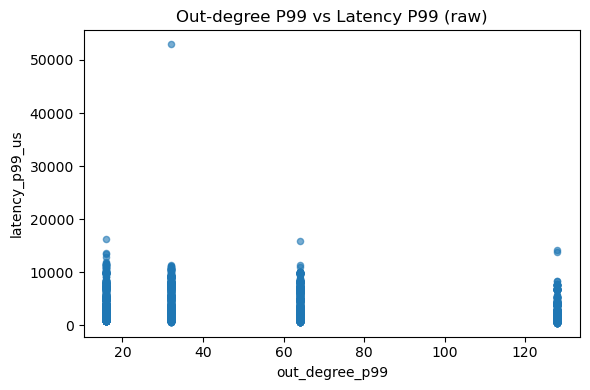

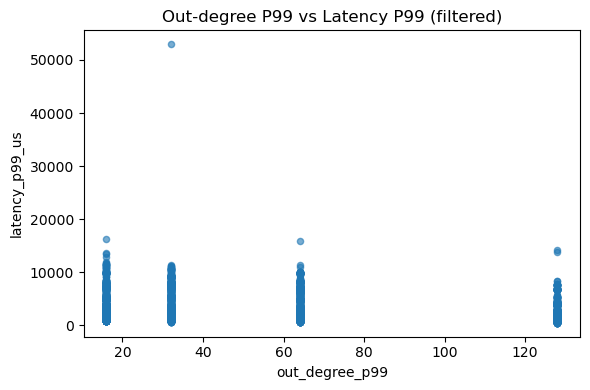

In [4]:
import matplotlib.pyplot as plt

fig_dir = (REPORT_DIR / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)

ax = df.plot.scatter(x='out_degree_p99', y='latency_p99_us', alpha=0.6, figsize=(6, 4))
ax.set_title('Out-degree P99 vs Latency P99 (raw)')
plt.tight_layout()
plt.savefig(fig_dir / 'outdegree_p99_vs_latency_p99_raw.png', dpi=150)

if filtered_df is not None:
    ax = filtered_df.plot.scatter(x='out_degree_p99', y='latency_p99_us', alpha=0.6, figsize=(6, 4))
    ax.set_title('Out-degree P99 vs Latency P99 (filtered)')
    plt.tight_layout()
    plt.savefig(fig_dir / 'outdegree_p99_vs_latency_p99_filtered.png', dpi=150)

print('Saved figures to', fig_dir)


Saved figures to /home/gt/research/DiskANN/scripts/paramAnalysis/gridSearch/outputFiles/analyze/siftsmall01/figures


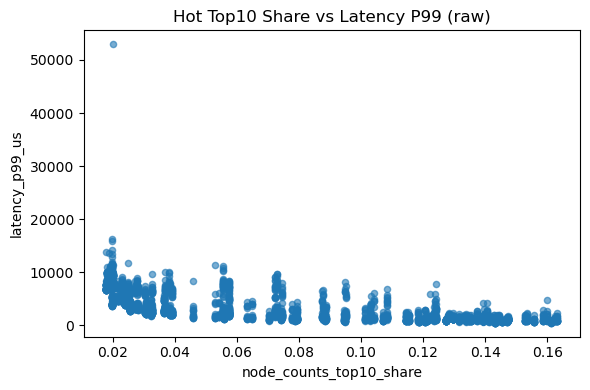

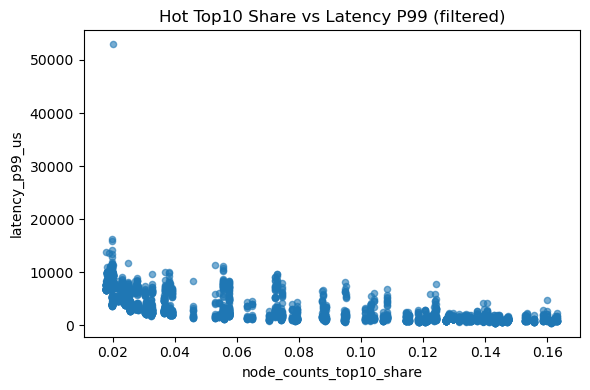

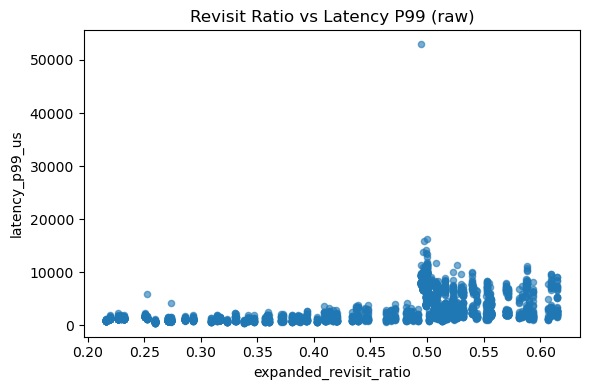

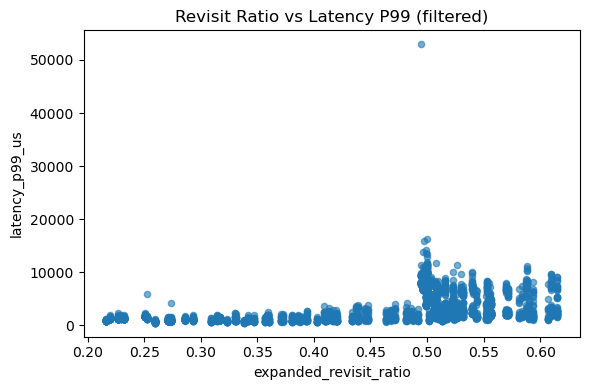

In [5]:
import matplotlib.pyplot as plt

fig_dir = (REPORT_DIR / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)

ax = df.plot.scatter(x='node_counts_top10_share', y='latency_p99_us', alpha=0.6, figsize=(6, 4))
ax.set_title('Hot Top10 Share vs Latency P99 (raw)')
plt.tight_layout()
plt.savefig(fig_dir / 'hot_top10_vs_latency_p99_raw.png', dpi=150)

if filtered_df is not None:
    ax = filtered_df.plot.scatter(x='node_counts_top10_share', y='latency_p99_us', alpha=0.6, figsize=(6, 4))
    ax.set_title('Hot Top10 Share vs Latency P99 (filtered)')
    plt.tight_layout()
    plt.savefig(fig_dir / 'hot_top10_vs_latency_p99_filtered.png', dpi=150)

ax = df.plot.scatter(x='expanded_revisit_ratio', y='latency_p99_us', alpha=0.6, figsize=(6, 4))
ax.set_title('Revisit Ratio vs Latency P99 (raw)')
plt.tight_layout()
plt.savefig(fig_dir / 'revisit_vs_latency_p99_raw.png', dpi=150)

if filtered_df is not None:
    ax = filtered_df.plot.scatter(x='expanded_revisit_ratio', y='latency_p99_us', alpha=0.6, figsize=(6, 4))
    ax.set_title('Revisit Ratio vs Latency P99 (filtered)')
    plt.tight_layout()
    plt.savefig(fig_dir / 'revisit_vs_latency_p99_filtered.png', dpi=150)

print('Saved figures to', fig_dir)
